### Importar base de dados e instalar framework de recomendação

In [3]:
!python3 -m pip install wget
import wget
!python3 -m wget https://github.com/mmanzato/6EABDARecSys/raw/main/dataset/AmazonMusic.tar.xz
!tar -xf AmazonMusic.tar.xz
!python3 -m pip install caserecommender

100% [....................................................] 23861964 / 23861964
Saved under AmazonMusic.tar (1).xz
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python3.8 -m pip install --upgrade pip


### Importar bibliotecas

In [4]:
import pandas as pd
import numpy as np

### Explorar Dados

In [8]:
dataset_metadata = pd.read_csv('./AmazonMusic/amazon_music_metadata.csv')
dataset_metadata.head()

,asin,title,Accessories,Acid Jazz,Acoustic Blues,Adult Alternative,Adult Contemporary,Africa,Afro Brazilian,Afro-Cuban,...,Wall Stickers,Wall Switches,Washers,Wave Washers & Wave Springs,Wedding Music,West Coast,West Coast Blues,Western Swing,World Dance,World Music
0,5555991584,Memory of Trees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6308051551,Dont Drink His Blood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7901622466,On Fire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B0000000ZW,Changing Faces,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B00000016W,Pet Sounds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
dataset = pd.read_json('./AmazonMusic/Digital_Music_5.json', lines=True)
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008"


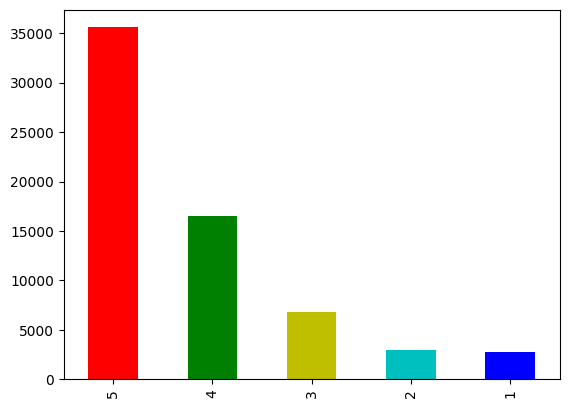

In [11]:
import matplotlib.pyplot as plt

dataset.overall.value_counts().plot(kind='bar', color=['r', 'g', 'y', 'c', 'b']);
plt.show()

In [12]:
df = dataset[['reviewerID', 'asin', 'overall']]
df.tail()

,reviewerID,asin,overall
64701,A1PQ1PESSO8CMO,B00KILDVEI,4
64702,A120RH58WVY4W6,B00KILDVEI,5
64703,A19VJ2IQLO50G0,B00KILDVEI,5
64704,AUDSM2CTLLW1Q,B00KILDVEI,3
64705,A1GN8UJIZLCA59,B00KILDVEI,1


In [13]:
df = df.merge(dataset_metadata[['asin', 'title']])
df.head()

,reviewerID,asin,overall,title
0,A3EBHHCZO6V2A4,5555991584,5,Memory of Trees
1,AZPWAXJG9OJXV,5555991584,5,Memory of Trees
2,A38IRL0X2T4DPF,5555991584,5,Memory of Trees
3,A22IK3I6U76GX0,5555991584,5,Memory of Trees
4,A1AISPOIIHTHXX,5555991584,4,Memory of Trees


### Números de usuários e número de itens

In [14]:
print(
"""
Número de usuários: {}
Número de itens: {}
Número de interações: {}
""".format(
    df.reviewerID.nunique(),
    df.asin.nunique(),
    df.shape[0]
)
)


Número de usuários: 5148
Número de itens: 2582
Número de interações: 51796



### Mapeamento em idx

In [15]:
map_users = {user: idx for idx, user in enumerate(df.reviewerID.unique())}
map_items = {item: idx for idx, item in enumerate(df.asin.unique())}

In [16]:
df['reviewerID'] = df['reviewerID'].map(map_users)
df['asin'] = df['asin'].map(map_items)
df

,reviewerID,asin,overall,title
0,0,0,5,Memory of Trees
1,1,0,5,Memory of Trees
2,2,0,5,Memory of Trees
3,3,0,5,Memory of Trees
4,4,0,4,Memory of Trees
...,...,...,...,...
51791,3844,2581,5,The Best Of Survivor
51792,1071,2581,3,The Best Of Survivor
51793,3469,2581,5,The Best Of Survivor
51794,2837,2581,5,The Best Of Survivor


In [17]:
map_title = {}

for _, row in df.iterrows():
    map_title[row.asin] = row.title

In [18]:
len(map_title)
map_title[100]

'Night Ride Home'

In [19]:
# qtd interações dos usuários
df.groupby('reviewerID').count()

,asin,overall,title
reviewerID,,,
0,7,7,7
1,16,16,16
2,12,12,12
3,6,6,6
4,5,5,5
...,...,...,...
5143,1,1,1
5144,1,1,1
5145,1,1,1


### Divisão do dataset

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train, test = train_test_split(df, test_size=.2, random_state=2)

In [22]:
train.to_csv('train.txt', index=False, header=False, sep='\t')
test.to_csv('test.txt', index=False, header=False, sep='\t')

In [23]:
! ls -l

total 104344
-rw-rw-r--@ 1 manzato  staff   2820977 Sep 28 14:24 3. Algoritmos Não Personalizados.pptx
drwxr-xr-x  6 manzato  staff       192 Sep 29 14:20 AmazonMusic
-rw-r--r--  1 manzato  staff  23861964 Sep 29 14:20 AmazonMusic.tar (1).xz
-rw-r--r--  1 manzato  staff  23861964 Sep 29 14:18 AmazonMusic.tar.xz
-rw-rw-r--@ 2 manzato  staff     92207 Sep 29 14:56 Recomendação Não Personalizada.ipynb
-rw-r--r--  1 manzato  staff     74632 Jul 18  2020 dict_title.npy
-rw-r--r--  1 manzato  staff    291777 Sep 29 14:56 test.txt
-rw-r--r--  1 manzato  staff   1177686 Sep 29 14:56 train.txt


In [24]:
test.shape[0], train.shape[0]

(10360, 41436)

### Recomendadores

## Prever notas

In [25]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

In [26]:
MostPopular('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 5099 users and 2582 items (41436 interactions) | sparsity:: 99.69%
test data:: 3818 users and 2288 items (10360 interactions) | sparsity:: 99.88%

prediction_time:: 0.388997 sec


Eval:: MAE: 0.741405 RMSE: 1.001254 


In [27]:
df_pred = pd.read_csv('out_mp_pred.txt', sep='\t', names=['reviewerID', 'asin', 'pred'])
df_pred.head()

,reviewerID,asin,pred
0,0,0,4.722222
1,0,959,4.394737
2,1,667,4.809524
3,2,428,4.529412
4,2,0,4.722222


In [28]:
test[test.reviewerID == 0]

,reviewerID,asin,overall,title
0,0,0,5,Memory of Trees
18167,0,959,5,Ray of Light


In [29]:
df_pred = df_pred.merge(test)

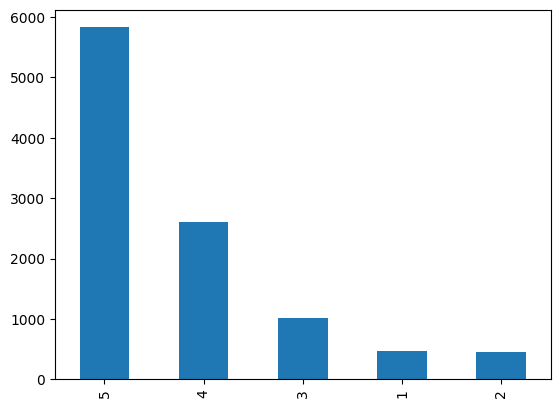

In [31]:
df_pred.overall.value_counts().plot(kind='bar')
plt.show()

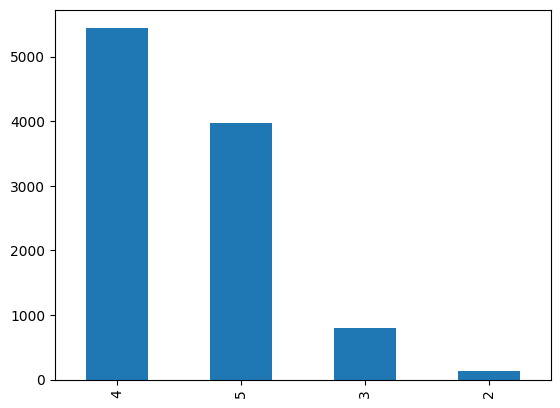

In [32]:
df_pred['pred'] = df_pred['pred'].apply(round) 
df_pred.pred.value_counts().plot(kind='bar');
plt.show()

### Top N

In [33]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular as MPR

In [34]:
MPR('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 5099 users and 2582 items (41436 interactions) | sparsity:: 99.69%
test data:: 3818 users and 2288 items (10360 interactions) | sparsity:: 99.88%

prediction_time:: 37.846303 sec


Eval:: PREC@1: 0.016763 PREC@3: 0.012397 PREC@5: 0.011158 PREC@10: 0.010739 RECALL@1: 0.006064 RECALL@3: 0.014079 RECALL@5: 0.021043 RECALL@10: 0.042721 MAP@1: 0.016763 MAP@3: 0.024424 MAP@5: 0.027933 MAP@10: 0.031907 NDCG@1: 0.016763 NDCG@3: 0.031874 NDCG@5: 0.039165 NDCG@10: 0.051415 


In [35]:
MPR('train.txt', 'test.txt', 'out_mp_pred_binary.txt', as_binary=True).compute(as_table=True, metrics=['PREC'])

[Case Recommender: Item Recommendation > Most Popular]

train data:: 5099 users and 2582 items (41436 interactions) | sparsity:: 99.69%
test data:: 3818 users and 2288 items (10360 interactions) | sparsity:: 99.88%

prediction_time:: 4.421495 sec


PREC@1	PREC@3	PREC@5	PREC@10	
0.017287	0.014493	0.012886	0.011001	


In [36]:
ranking = pd.read_csv('out_mp_pred.txt', sep='\t', names=['reviewerID', 'asin', 'score'])
ranking['title'] = ranking.asin.map(map_title)
ranking.head(15)

,reviewerID,asin,score,title
0,0,2133,777.0,Get Rich Or Die Tryin
1,0,1770,693.0,The Marshall Mathers LP
2,0,2039,660.0,The Eminem Show [Limited Edition w/ Bonus DVD]
3,0,169,632.0,All Eyez on Me
4,0,459,607.0,Thriller
5,0,1955,598.0,Blueprint
6,0,2212,594.0,Speakerboxxx/ The Love Below
7,0,2408,564.0,The Documentary
8,0,992,559.0,Are You Experienced
9,0,1666,545.0,Chronic 2001


In [37]:
ranking = pd.read_csv('out_mp_pred_binary.txt', sep='\t', names=['reviewerID', 'asin', 'score'])
ranking['title'] = ranking.asin.map(map_title)
ranking.head(15)

,reviewerID,asin,score,title
0,0,2133,223.0,Get Rich Or Die Tryin
1,0,2418,218.0,The Massacre
2,0,2039,168.0,The Eminem Show [Limited Edition w/ Bonus DVD]
3,0,1770,162.0,The Marshall Mathers LP
4,0,2212,148.0,Speakerboxxx/ The Love Below
5,0,2408,146.0,The Documentary
6,0,169,134.0,All Eyez on Me
7,0,1955,134.0,Blueprint
8,0,459,126.0,Thriller
9,0,2150,122.0,Meteora
